# PART 1

### Question 1 
Join the House Prices - Advanced Regression Techniques competition on Kaggle. Download the
training and test data.

In [813]:
# imports .
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# load train and test datasets.
df_train = pd.read_csv('./h1data/train.csv')
df_test = pd.read_csv('./h1data/test.csv')

In [814]:
# helper plot function
def custom_plot(ax, xlab="", ylab="", title=""):
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)

In [815]:
# Save sale conditions and central air before 1HE to plot later.
sale_cond = df_train["SaleCondition"]
central_air = df_train["CentralAir"]

### Question 2
Give 3 examples of continuous and categorical features in the dataset; choose one feature of each
type and plot the histogram to illustrate the distribution.

#### 2.1. Continuous features
Three examples of continuous features in the dataset are the following:
- LotFrontage
- LotArea
- GarageArea

The figure below shows a histogram of the lot areas.

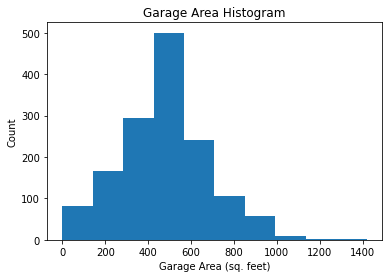

In [816]:
# Histogram for LotArea
plt.hist(df_train["GarageArea"])
custom_plot(plt.gca(), xlab = "Garage Area (sq. feet)", ylab = "Count", title = "Garage Area Histogram")

#### 2. 2 Categorical features
Three examples of categorical features in the dataset are the following:
- Street
- Lot Shape
- Utilities

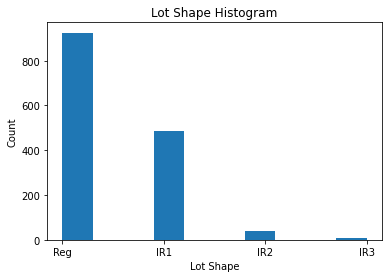

In [817]:
# Histogram for LotShape
plt.hist(df_train["LotShape"])
custom_plot(plt.gca(), xlab = "Lot Shape", ylab = "Count", title = "Lot Shape Histogram")

### Question 3
Pre-process your data, explain your pre-processing steps, and the reasons why you need them.
(Hint: data pre-processing steps can include but are not restricted to: dealing with missing values,
normalizing numerical values, dealing with categorical values etc.)

#### 3.1 Concatenate train and test datasets
First I decided to concatenate training and test datasets to perform a consistent pre-processing on both datasets. I keep track of the size of the train datasets to split them back after pre-processing.

In [818]:
len_train = len(df_train)
df = pd.concat([df_train, df_test])

#### 3.2 Deal with missing values and interpolate

Secondly, I remove all missing values. There are several ways to treat missing values.

For categorical values with a "NA" category, we manually fill them using the __fillna__ pandas function.
The feature "MasVnrType" has a "None" category, so we manually fill it with that.
For all the other columns we use the pandas function __interpolate("nearest")__ which fills the missing values copying the one of the nearest observation.

In [819]:
na_cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "GarageType", \
           "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature",  \
           "ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "FireplaceQu"]


for col in na_cols:
    df[col].fillna("NA", inplace = True)

df["MasVnrType"].fillna("None", inplace = True) # has 8 NaN and a defined "None" Category, cleanup.

df = df.interpolate("nearest")

#### 3.3 Normalization
A further data normalization approach that we tried is to normalize large numerical data. However, we obtained worse results after normalization, so we decided to remove it from the final submission.

In [820]:
def norm_cols(df, col_names):
    for col in col_names :
        max_val = float(df[col].max())
        df[col + "_Norm"] = df[col] / max_val
    
    df.drop(columns = col_names, inplace=True)

    
# cols_to_norm = ["BsmtFinSF1", "LotArea", "MasVnrArea", "WoodDeckSF", "LotFrontage", \
#                 "2ndFlrSF", "1stFlrSF", "GarageArea", "OpenPorchSF", "BsmtUnfSF", \
#                 "TotalBsmtSF"] 
# norm_cols(df, cols_to_norm)

#### 3.4 Binning 
Another way to pre-process numerical values is to discretize them into bins. We tried this approach using the builtin __qcut__ function in pandas and applied it on dates. We defined 5 bins from "Very Old" to "New" to caption binned dates information. However, we found in testing that this pre-processing step was also worsening the performance of the model, and therefore removed it from the final submission.

In [821]:
# cols_to_bin = ["GarageYrBlt", "YearRemodAdd", "YearBuilt"] 
# bin_labels = ["Very Old", "Old", "Average", "Recent", "New"]

# for col in cols_to_bin:
#     df[col + "_Bin"] = pd.qcut(df[col], q = [0, .2, .4, .6, .8, 1], labels = bin_labels)

# df.drop(columns = cols_to_bin, inplace=True)


#### 3.5 Deal with Categorical Values

The two main methods to deal with categorical values are one hot encoding and ordered numericals.
While the first one is great for features with few possible categories, the second one works best for features in which the categories encompass a qualitative information on the state of something, i.e. the condition of a house feature from "Excellent" to "Poor". 

We defined a function to transform all these categories in ordered numericals:

In [822]:
levels = ["NA", "Po", "Fa", "TA", "Gd", "Ex"]
def to_ord_num(df, col_name):
    df[col_name + "_Ord"] = df.apply(
        lambda x:  levels.index(x[col_name]),
    axis=1)
    df.drop(columns = [col_name], inplace = True)

In [823]:
ord_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", \
            "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
for col in ord_cols:
    to_ord_num(df, col)
    

To one hot encode categorical columns we simply leveraged the builtin __get_dummies__ pandas function.
This function automatically creates a new column named "{col_name}_{category}" for each categorical entry, then drops the original column.

In [824]:
df = pd.get_dummies(df)

#### 3.6 Split back test and train datasets
Finally, we split the concatenated dataset back to train and test.

In [825]:
df_train = df.iloc[:len_train, :]
df_test = df.iloc[len_train:, :]

### Question 4
One common method of pre-processing categorical features is to use a one-hot encoding (OHE).
Suppose that we start with a categorical feature xj
, taking three possible values: xj ∈ {R,G,B}. A
one-hot encoding of this feature replaces xj with three new features: xj R,xjG ,xj B . Each feature
contains a binary value of 0 or 1, depending on the value taken by xj
. For example, if xj = G, then
xjG = 1 and xj R = xj B = 0.
Give some examples of features that you think should use a one-hot encoding and explain why.
Convert at least one feature to a one-hot encoding (you can use your own implementation, or that
in pandas or scikit-learn) and visualize the results by plotting feature histograms of the original
feature and its new one-hot encoding.

In step 3.6 we perform 1HE for all categorical features in the dataset. 
One hot encoding generates *n* new features where *n* is the number of unique values the feature can assume.
For this reason, categories with many possible values are not suitable for one hot encoding, as it results in many new features that scatter information around. 

Furthermore, qualitative categorical features, i.e. features that describe the qualitative state of something using a set of categories like ['Excellent', 'Average', 'Bad'] are optimal candidates to be transformed in ordered numericals. That is because the distance between numbers will convey the distance between levels of quality.

Therefore, we considered good 1HE candidates the features with a small amount of categories and which are not qualitative. The histograms below show the old and new features for the following:
- SaleCondition
- CentralAir

We decided to plot two features to visually showcase that CentralAir is an ideal candidate for 1HE being a binary categorical feature, compared to SaleCondition that can assume 6 possible values.

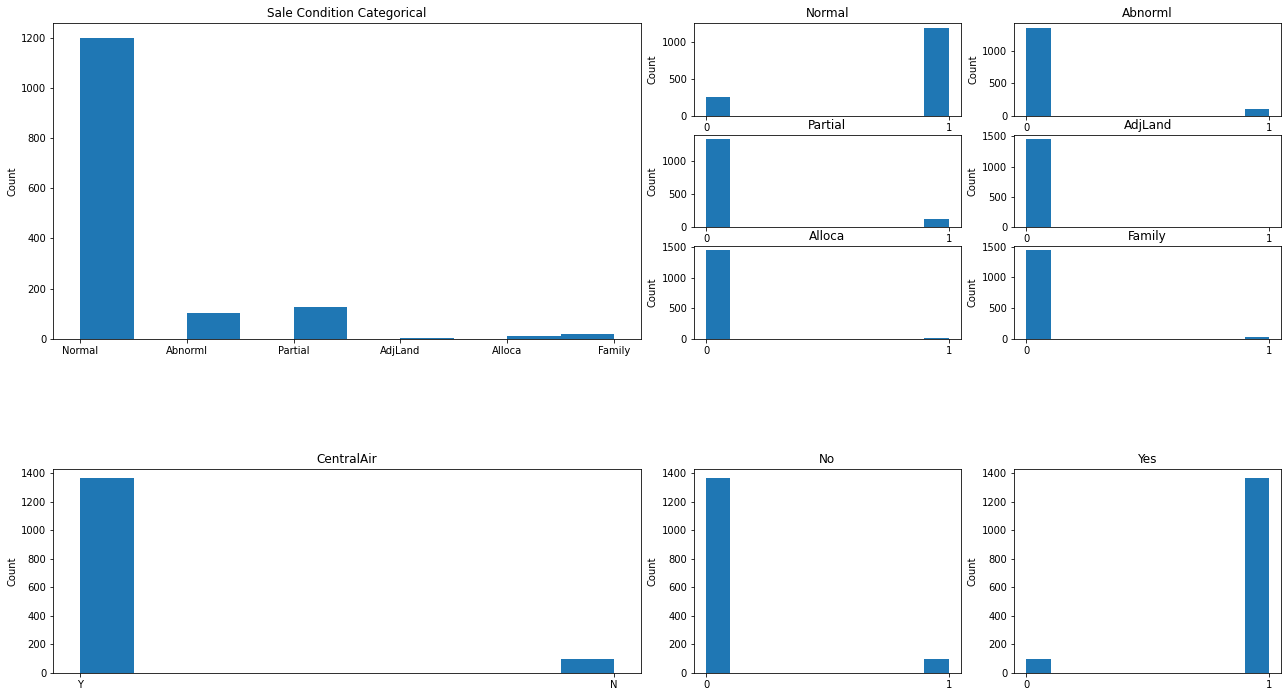

In [826]:
# SaleCondition
fig = plt.figure(figsize = (22, 14))

gs = fig.add_gridspec(7,4)
ax = fig.add_subplot(gs[0:3, 0:2])
ax.hist(sale_cond)
custom_plot(ax, xlab = "", ylab = "Count", title = "Sale Condition Categorical")

i = 0
j = 2
for cat in sale_cond.unique():
    ax = fig.add_subplot(gs[i, j])
    ax.hist(df_train["SaleCondition_" + cat])
    custom_plot(ax, xlab = "", ylab = "Count", title = cat)
    ax.set_xticks([0, 1])
    j += 1
    if j == 4:
        j = 2
        i += 1
        
ax = fig.add_subplot(gs[4:6, 0:2])
ax.hist(central_air)
custom_plot(ax, xlab = "", ylab = "Count", title = "CentralAir")

ax = fig.add_subplot(gs[4:6, 2])
ax.hist(df_train["CentralAir_N"])
custom_plot(ax, xlab = "", ylab = "Count", title = "No")
ax.set_xticks([0, 1])

ax = fig.add_subplot(gs[4:6, 3])
ax.hist(df_train["CentralAir_Y"])
custom_plot(ax, xlab = "", ylab = "Count", title = "Yes")
ax.set_xticks([0, 1])


### Question 5
Using ordinary least squares (OLS), try to predict house prices on this dataset. Choose the features
(or combinations of features) you would like to use or ignore, provided you justify your choice.
Evaluate your predictions on the training set using the MSE and the R
2
score. For this question,
you need to implement OLS from scratch without using any external libraries or packages.

#### 5.1 Correlation Matrix
We use a correlation matrix to dynamically pick features that are correlated to the target feature *SalePrice* above a certain treshold. Moreover, we scan the correlation matrix to find highly correlated pairs of features, using another threshold, in order to discard one of the two since the information that they convey is very similar.

We performed some manual hyperparameter optimization of the two thresholds via visual inspection of the correlation matrix.

In [827]:
cm = df_train.corr()

th_saleprice = 0.05
th_corr_pairs = 0.75

highly_corr_saleprice_bool = np.abs(cm.values) > th_saleprice
highly_corr_pairs_bool = np.abs(cm.values) > th_corr_pairs

high_corr_pairs = [(cm.columns[i], cm.columns[j]) for i, j in zip(*np.where(highly_corr_pairs_bool)) 
                 if i < j and cm.columns[j] != "SalePrice"] 
high_info_cols = {cm.columns[i] for i, j in zip(*np.where(highly_corr_saleprice_bool)) 
                 if i < j and cm.columns[j] == "SalePrice"}

for c1, c2 in high_corr_pairs:
    if c1 in high_info_cols and c2 in high_info_cols:
        high_info_cols.remove(c1)

df_train_processed = df_train[list(high_info_cols) + ["SalePrice"]]

#### 5.2 OLS 
We defined a new class *MyOLS* to train the model and predict. We use it to train the model on training set and predict the prices of the training set itself.

In [828]:
class MyOLS:
    def __init__(self, X, Y):
        self._theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

    def predict(self, X_test):
        predictions = X_test.dot(self._theta_best)
        return predictions

In [829]:
Y = df_train_processed["SalePrice"]
X = df_train_processed.drop(columns=["SalePrice"])

ols = MyOLS(X, Y)
predictions = ols.predict(X)
predictions.to_csv('train_results_h1.csv', sep=',', index=False)

Then, we defined two custom functions *my_MSE* and *my_RSquared* to respectively compute the two metrics on the model predictions on the training set.

In [830]:
def my_MSE(y, y_pred):
    return 0.5 * np.mean((y - y_pred) ** 2)
def my_RSquared(y, y_pred):
    return 1 - sum((y - y_pred) ** 2)/ sum((y - np.mean(y)) ** 2)

In [831]:
print("MSE: ", my_MSE(Y, predictions))
print("RSquared: ", my_RSquared(Y, predictions))


MSE:  626857887.7445887
RSquared:  0.8012117009278596


### Question 6 
Train your model using all of the training data (all data points, but not necessarily all the features),
and test it using the testing data. Submit your results to Kaggle.

#### Kaggle Score: 0.21172

In [832]:
df_test_processed = df_test[high_info_cols]
test_predictions = ols.predict(df_test_processed)

pred_df = pd.DataFrame(test_predictions, columns = ['SalePrice'])
pred_df.reset_index(inplace=True)
pred_df = pred_df.rename(columns = {'index':'Id'})
pred_df["Id"] = pred_df["Id"].apply(lambda x : x + len(df_train) + 1)
pred_df.to_csv('results_h1.csv', sep=',', index=False)